In [6]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom

from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

import pickle
import copy
from shapely import geometry

In [7]:
z500_anoms = xr.open_dataset('/glade/scratch/jhayron/Data4Predictability/WeeklyAnoms_withTrends/Z500_ERA5.nc')

In [8]:
# region for clustering
lat0=10; lat1=70; lon0=210; lon1=320
z500_anoms_region = z500_anoms.where((z500_anoms.lat>=lat0)&(z500_anoms.lat<=lat1)&\
                   (z500_anoms.lon>=lon0)&(z500_anoms.lon<=lon1),drop=True)

In [9]:
var_name = 'Z_anomalies'

In [10]:
z500_anoms_flattened = z500_anoms_region.stack(flat=('lat','lon')).transpose('time','flat')[var_name]
# z500_anoms_flattened = z500_anoms_flattened.data

# PCA

In [11]:
# create pca object
pca_obj = PCA(12, whiten=True)

# fit pca with era5
pca_obj = pca_obj.fit(z500_anoms_flattened)

# transform era5 data with pca
z500_anoms_transformed = pca_obj.transform(z500_anoms_flattened)

print(f'Variance explained: {pca_obj.explained_variance_ratio_ * 100}')
print(
f'Cumulative sum of variance explained for EOF1 and EOF2: {np.cumsum(pca_obj.explained_variance_ratio_) * 100}'
)

Variance explained: [27.15613706 17.24873973 11.93931682  9.22324356  8.2528078   6.49823632
  3.75648585  2.73382544  2.3067914   1.83526842  1.57799514  1.08336491]
Cumulative sum of variance explained for EOF1 and EOF2: [27.15613706 44.40487679 56.34419361 65.56743717 73.82024497 80.31848129
 84.07496715 86.80879259 89.115584   90.95085242 92.52884756 93.61221247]


# k-means

In [12]:
# train kmeans
k_means = KMeans(n_clusters=4,
                 init='k-means++',
                 n_init=10000,
                 max_iter=300,
                 tol=0.0001,
                 verbose=0,
                 random_state=0).fit(z500_anoms_transformed)

print(f'inertia: {k_means.inertia_}')

inertia: 21390.23047901537


In [13]:
import joblib

filename = r'/glade/work/jhayron/Data4Predictability/models/PCA_ERA5_20230731_withTrends.mdl'
joblib.dump(pca_obj,filename)

filename = r'/glade/work/jhayron/Data4Predictability/models/KMeans_ERA5_20230731_withTrends.mdl'
joblib.dump(k_means,filename)


['/glade/work/jhayron/Data4Predictability/models/KMeans_ERA5_20230731_withTrends.mdl']

In [14]:
filename = r'/glade/work/jhayron/Data4Predictability/models/PCA_ERA5_20230731_withTrends.pkl'
pickle.dump(pca_obj, open(filename, 'wb'))

filename = r'/glade/work/jhayron/Data4Predictability/models/KMeans_ERA5_20230731_withTrends.pkl'
pickle.dump(k_means, open(filename, 'wb'))

In [15]:
anomalies_afterPCA = copy.deepcopy(z500_anoms_flattened)
anomalies_afterPCA.data = pca_obj.inverse_transform(z500_anoms_transformed)
anomalies_afterPCA = anomalies_afterPCA.unstack('flat')

## load models

In [32]:
import joblib
pca_obj = joblib.load(r'/glade/work/jhayron/Data4Predictability/models/PCA_ERA5_20230731_withTrends.mdl')
k_means = joblib.load(r'/glade/work/jhayron/Data4Predictability/models/KMeans_ERA5_20230731_withTrends.mdl')
# data_era5_train = pca_obj.transform(data_era5_train)

In [33]:
z500_anoms_transformed = pca_obj.transform(z500_anoms_flattened)

In [34]:
anomalies_afterPCA = copy.deepcopy(z500_anoms_flattened)
anomalies_afterPCA.data = pca_obj.inverse_transform(z500_anoms_transformed)
anomalies_afterPCA = anomalies_afterPCA.unstack('flat')

In [35]:
weather_patterns = k_means.predict(z500_anoms_transformed)

where0 = np.where(weather_patterns==0)
where1 = np.where(weather_patterns==1)
where2 = np.where(weather_patterns==2)
where3 = np.where(weather_patterns==3)

In [36]:
len(weather_patterns)

2073

In [37]:
pd.DataFrame(weather_patterns,index=pd.to_datetime(anomalies_afterPCA.time)).\
    to_csv('/glade/work/jhayron/Data4Predictability/WR_Series_20230731_withTrends.csv')

In [38]:
print('Pattern #0:')
print(np.round(100*len(where0[0])/len(weather_patterns),2))

print('Pattern #1:')
print(np.round(100*len(where1[0])/len(weather_patterns),2))

print('Pattern #2:')
print(np.round(100*len(where2[0])/len(weather_patterns),2))

print('Pattern #3:')
print(np.round(100*len(where3[0])/len(weather_patterns),2))

Pattern #0:
22.82
Pattern #1:
24.84
Pattern #2:
31.36
Pattern #3:
20.98


In [39]:
p0 = np.round(len(where0[0])/len(weather_patterns),2)
p1 = np.round(len(where1[0])/len(weather_patterns),2)
p2 = np.round(len(where2[0])/len(weather_patterns),2)
p3 = np.round(len(where3[0])/len(weather_patterns),2)

In [40]:
anomalies_afterPCA = anomalies_afterPCA / 9.82

In [41]:
mean_wr_0 = anomalies_afterPCA[where0].mean(axis=0)
mean_wr_1 = anomalies_afterPCA[where1].mean(axis=0)
mean_wr_2 = anomalies_afterPCA[where2].mean(axis=0)
mean_wr_3 = anomalies_afterPCA[where3].mean(axis=0)

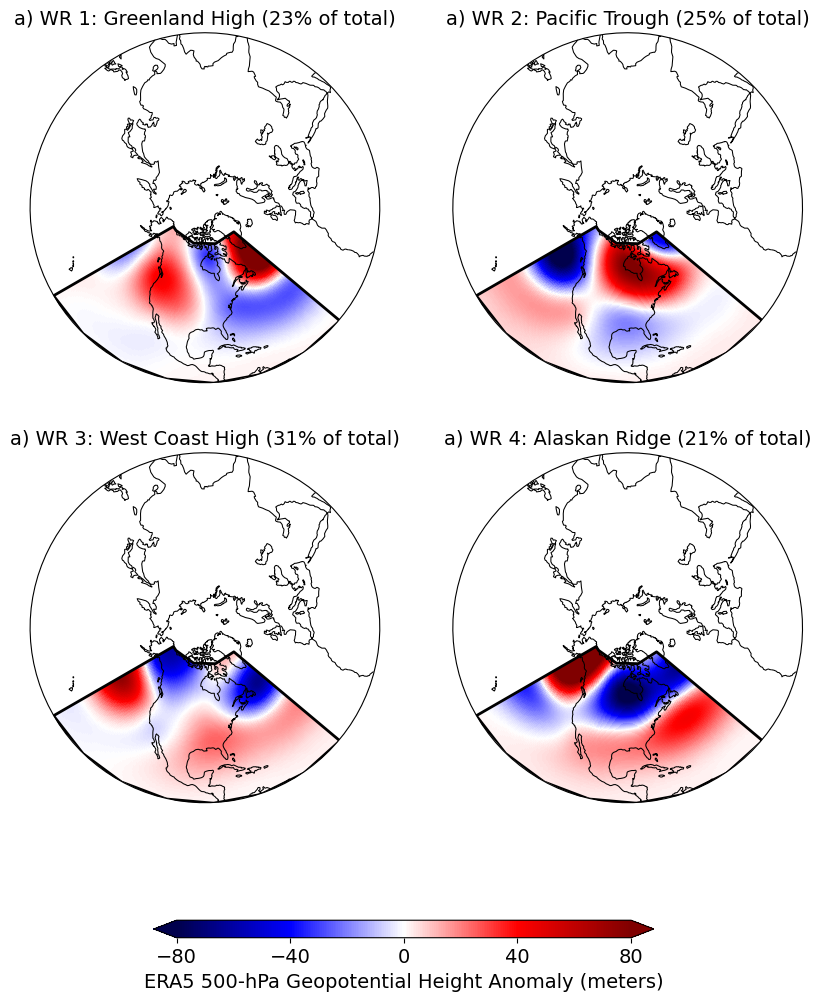

In [42]:
lons, lats = np.meshgrid(anomalies_afterPCA.lon, anomalies_afterPCA.lat)
names = ['Greenland High','Pacific Trough','West Coast High','Alaskan Ridge']
arrays = [mean_wr_0,mean_wr_1,mean_wr_2,mean_wr_3]
probs = [p0,p1,p2,p3]

# ---

fig, axs = plt.subplots(
    2, 2,
    subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-90+360)),
    figsize=(10, 10))

# ---

for iregime in range(0,4):
    if iregime == 0 :
        indax = (0,0)
    elif iregime == 1:
        indax = (0,1)
    elif iregime == 2:
        indax = (1,0)
    elif iregime == 3:
        indax = (1,1)
    
    pm = axs[indax[0]][indax[1]].pcolormesh(lons, lats, arrays[iregime],
                         transform=ccrs.PlateCarree(),
                         vmin=-80, vmax=80, cmap='seismic')

    axs[indax[0]][indax[1]].set_title(
        f'a) WR {iregime+1}: {names[iregime]} ({int(np.around((probs[iregime]) * 100))}% of total)', 
        fontsize=14)

    axs[indax[0]][indax[1]].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
    axs[indax[0]][indax[1]].margins(x=0, y=0)

    axs[indax[0]][indax[1]].set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    axs[indax[0]][indax[1]].set_boundary(circle, transform=axs[indax[0]][indax[1]].transAxes)

    geom = geometry.box(minx=210-360, maxx=320-360, miny=10, maxy=70)
    # 10-70°N, 150-40°W
    axs[indax[0]][indax[1]].add_geometries([geom], crs=cartopy.crs.PlateCarree(),
                             facecolor='none', edgecolor='k', lw=2.)
    
# ---

cbar_ax = fig.add_axes([0.25, -0.025, 0.5, 0.0175])

ticks_1 = [-80, -40, 0, 40, 80]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=14)
cbar.set_label(
    r'ERA5 500-hPa Geopotential Height Anomaly (meters)', fontsize=14)

# ---

# plt.tight_layout()
# plt.savefig("../../Figures/WR_ERA5_v3.png", bbox_inches='tight', dpi=500)
plt.show()

# ---


In [43]:
mean_wr_0 = z500_anoms.Z_anomalies[where0].mean(axis=0)/9.82
mean_wr_1 = z500_anoms.Z_anomalies[where1].mean(axis=0)/9.82
mean_wr_2 = z500_anoms.Z_anomalies[where2].mean(axis=0)/9.82
mean_wr_3 = z500_anoms.Z_anomalies[where3].mean(axis=0)/9.82

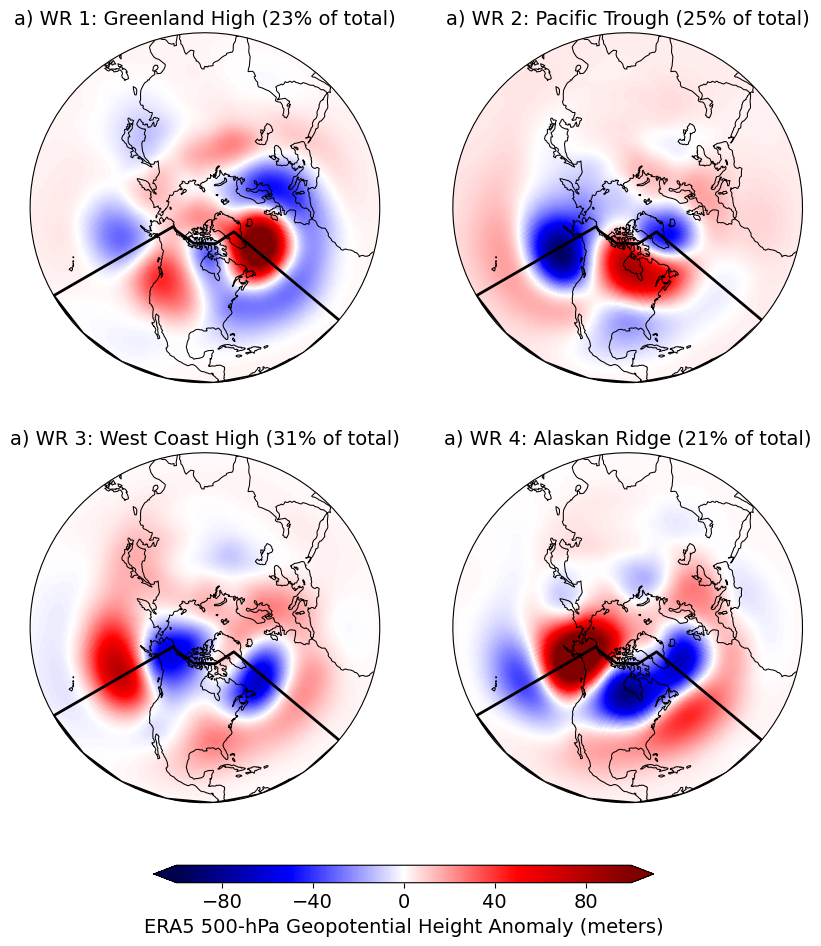

In [44]:
lons, lats = np.meshgrid(z500_anoms.lon, z500_anoms.lat)
names = ['Greenland High','Pacific Trough','West Coast High','Alaskan Ridge']
arrays = [mean_wr_0,mean_wr_1,mean_wr_2,mean_wr_3]
probs = [p0,p1,p2,p3]

# ---

fig, axs = plt.subplots(
    2, 2,
    subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-90+360)),
    figsize=(10, 10))

# ---

for iregime in range(0,4):
    if iregime == 0 :
        indax = (0,0)
    elif iregime == 1:
        indax = (0,1)
    elif iregime == 2:
        indax = (1,0)
    elif iregime == 3:
        indax = (1,1)
    
    pm = axs[indax[0]][indax[1]].pcolormesh(lons, lats, arrays[iregime],
                         transform=ccrs.PlateCarree(),
                         vmin=-100, vmax=100, cmap='seismic')

    axs[indax[0]][indax[1]].set_title(
        f'a) WR {iregime+1}: {names[iregime]} ({int(np.around((probs[iregime]) * 100))}% of total)', 
        fontsize=14)

    axs[indax[0]][indax[1]].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
    axs[indax[0]][indax[1]].margins(x=0, y=0)

    axs[indax[0]][indax[1]].set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    axs[indax[0]][indax[1]].set_boundary(circle, transform=axs[indax[0]][indax[1]].transAxes)

    geom = geometry.box(minx=210-360, maxx=320-360, miny=10, maxy=70)
    # 10-70°N, 150-40°W
    axs[indax[0]][indax[1]].add_geometries([geom], crs=cartopy.crs.PlateCarree(),
                             facecolor='none', edgecolor='k', lw=2.)
    
# ---

cbar_ax = fig.add_axes([0.25, 0.03, 0.5, 0.0175])

ticks_1 = [-80, -40, 0, 40, 80]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=14)
cbar.set_label(
    r'ERA5 500-hPa Geopotential Height Anomaly (meters)', fontsize=14)

# ---

# plt.tight_layout()
plt.savefig("WR_ERA5_20230731_withTrends.png", bbox_inches='tight')
plt.show()

# ---
